<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1] Setting up Environment and Install Requirements

## 1.1 Set Working Directory, Install Requirements

In [ ]:
import os
import sys
# Set Path
from google.colab import drive
drive.mount('/content/drive')
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 h

## 1.2 Load and Initialize the Movie Registration Class

In [ ]:
!#Load Libraries
import gc
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import re
from sources.ChinaFilm.Record_Registration import Registration # assume relative path at path_wd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
dy_reg = Registration(driver)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: use options instead of chrome_options
  from ipykernel import kernelapp as app


## 1.3 Load Latest Registration Publication

In [ ]:
os.chdir('/content/drive/MyDrive/Github/Content/sources/ChinaFilm')
##########################################
# Use update_first=True to get latest records from China Film's Website
df = dy_reg.Refined_Records(update_first =False)
##########################################
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name,]
df_curr.columns

Index(['电影类别', '备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期',
       '公示批次名称', '备案详细页链接', '公示批次链接', '公示年', '公示批次起始', '类型', '备案申请年份',
       '备案立项年度顺序号', '公示覆盖期间', '公示覆盖天数'],
      dtype='object')

## 1.4 Load Title Prediction Model (REQUIRED GPU)

In [ ]:
# Prediction Model using Title Prediction BERT-based model
os.chdir('/content/drive/MyDrive/Github/Content/tools/articles')
!pip install -r /content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/requirements.txt
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import json
from tensorflow import keras
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder

dict_path ='/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/vocab.txt'
config_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_model.ckpt'
maxlen = 256
topk = 1

token_dict, keep_tokens = load_vocab(
dict_path=dict_path,
simplified=True,
startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

# Initialize model and load weights
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='unilm',
    keep_tokens=keep_tokens,  # include only tokens in keep tokens
)
path_weights = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/weights/StarChaser_best_model.weights'
model.load_weights(path_weights)


class AutoTitle(AutoRegressiveDecoder):
    @AutoRegressiveDecoder.wraps(default_rtype='probas')

    def predict(self, inputs, output_ids, states):
        token_ids, segment_ids = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        #####################
        return model.predict([token_ids, segment_ids])[:, -1]
        #####################

    def generate(self, text, topk=1):
        max_c_len = 256 - self.maxlen
        token_ids, segment_ids = tokenizer.encode(text, maxlen=max_c_len)
        output_ids = self.beam_search([token_ids, segment_ids],
                                      topk=topk)  # beam search
        return tokenizer.decode(output_ids)

autotitle = AutoTitle(start_id=None, end_id=tokenizer._token_end_id, maxlen=32)


# [2] Generating Article Contents

##2.1 2021年3月整月电影备案公示划重点

In [ ]:
issue_name = df_curr.loc[0,'公示批次起始'][0] + '年' + df_curr.loc[0,'公示批次起始'][1] +'月'
issue_name += df_curr.loc[0,'公示批次起始'][2]

# Title
T0 = '{year}年'.format(year=df_curr.loc[0,'公示批次起始'][0])
T0 += '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  T0 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
T0 += '电影备案公示划重点'
print(T0)

2021年3月电影备案公示划重点


##2.2 2021年4月28日,3月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《幕后英雄》,备案号为影剧备字〔2021〕第1360号,最近期的项目是《熊猫传奇——黑洞之吻》,备案号为影特备字〔2021〕第006号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


In [ ]:
# Obtain Variables
df_curr.loc[:,'公示日期'] = df_curr.loc[:,'公示日期'].astype('datetime64')
pub_year = df_curr.loc[0,'公示日期'].year
pub_month = df_curr.loc[0,'公示日期'].month
pub_day = df_curr.loc[0,'公示日期'].day
df_curr_sorted = df_curr.sort_values(['备案申请年份', '备案立项年度顺序号'])
df_type = df_curr.groupby('电影类别')['电影类别'].count().sort_values(ascending=False).rename('数量').to_frame().reset_index()

# Write Content
T1 = '\t'
T1 += '{year}年{month}月{day}日,'.format(year=pub_year, month=pub_month, day=pub_day)
T1 += '{month}月{part_of_month}的备案公示新鲜出炉！'.format(month=df_curr.loc[0,'公示批次起始'][1], part_of_month=df_curr.loc[0,'公示批次起始'][2])
T1 += '这一批次中，最遥远的项目是《{}》,'.format(df_curr_sorted.loc[0, '片名']) 
T1 += '备案号为{},'.format(df_curr_sorted.loc[0, '备案立项号'])
T1 += '最近期的项目是《{}》,'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
T1 += '备案号为{}。'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'])
T1 += '本次完成备案的共计'
for i, row in df_type.iterrows():
  if i == df_type.shape[0]-1:
    T1 = T1.rstrip('、')
    T1 += '以及{type}{n}部。'.format(type=row['电影类别'], n=row['数量'])
  else:
    T1 += '{type}{n}部、'.format(type=row['电影类别'], n=row['数量'])
print(T1)

	2021年4月28日,3月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《幕后英雄》,备案号为影剧备字〔2021〕第1360号,最近期的项目是《熊猫传奇——黑洞之吻》,备案号为影特备字〔2021〕第006号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## 2.3 本批次中，获得上市影视公司参投的项目预计有10部,占比4.0%。AI福彩慧眼识别出的重点关注项目有：
《发明一个夏天》,编剧：高亦可
备案单位：中国电影股份有限公司
胡舟回到年少时度过夏天的小镇，回想起曾经的玩伴唐露，以及小镇上神秘的河流。他决定追溯过往，解开困扰自己多年的梦境。

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_curr.loc[df_curr['备案单位'].str.contains(pat_public), ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
ids = [39,120,150, 170,230,231]
df_focus_narrowed = df_curr.loc[ids, ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
ls_ptitles = []
#for content in df_focus_narrowed['梗概'].tolist():
#    ls_ptitles.append(''.join(autotitle.generate(content,1)).lower())
ls_ptitles =  ['夏日之旅', '奔爱', '警花李贝', '合法父亲', '杨戬传奇之夺命天目', '土行术']

########
T2 = '\t'
T2 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
T2 += '占比{}%。'.format(df_focus.shape[0]/df_curr.shape[0]*100)
T2 += '慷田AI聚焦关注的有\n'

"""
for _, row in df_focus_narrowed.iterrows():
  T2 += '\n《{name}》\n编剧：{writer}'.format(name=row['片名'],writer=row['编剧'])
  T2 += '\n备案单位：{co}'.format(co=row['备案单位'])
  T2 += '\n{synopsis}\n'.format(synopsis=row['梗概'])
"""
print(T2)

	本批次中，预计有10部上市影视公司关联项目，占比4.0%。慷田AI聚焦关注的项目有



##2.3 本批次中，共有16家公司完成了两部或以上故事片或合拍片的备案，创造力满满。
中央宣传部电影卫星频道节目制作中心：《虫口夺粮》,《突破口》,《您别不爱听》,《地火》

In [ ]:
pat_film = '故事影片|合拍影片'
df_2plus_co = df_curr[df_curr['电影类别'].str.contains(pat_film)].groupby(['备案单位'])['备案单位'].count().sort_values(ascending=False).rename('数量').to_frame().reset_index()
pat_2plus_co = '|'.join(df_2plus_co.loc[df_2plus_co['数量']>1, '备案单位'].to_list())
df_2plus = df_curr[df_curr['电影类别'].str.contains(pat_film) & df_curr['备案单位'].str.contains(pat_2plus_co)]
df_2plus = df_2plus.loc[:,['备案单位','片名', '编剧', '梗概']]
df_count = df_2plus.groupby('备案单位')['备案单位'].count().rename('备案数量').reset_index()
df_2plus = df_2plus.merge(df_count, on='备案单位').sort_values('备案数量', ascending=False).reset_index(drop=True)

highlights = []
#for content in df_2plus['梗概'].to_list():
#    highlights.append(''.join(autotitle.generate(content,1)).lower())
highlights = ['虫灾中国', '城防图', '分流诊疗', '天地之光', '酒吧里的酒吧', '我们的婚姻', '铁甲少年', '星空筑梦', '楼上邻居', '小黄', '摩洛哥餐厅', '筱筱', '离婚七年', '妈妈的孩子', '桥', '我不能说', '危机危机', '合拍', '冬天', '平衡车小伙伴', '蝶皇', '村官的评测', '龙珠传奇', '东风小学贝书香', '白雪无泪', '老九', '乌龙丸之海防大冒险', '怪物', '三年高中岁月', '阿勒泰', '阿勒泰', '暗恋', '篮球之王', '天赐良心', '说走就走的旅行', '秦皇岛漫画']

df_2plus['划重点'] = pd.Series(highlights)
df_2plus['片单'] = df_2plus.groupby('备案单位')['片名'].transform(lambda x: ','.join("《" + x +"》"))
df_2plus_co = df_2plus[['备案单位','片单']].drop_duplicates()

##
T3 = '本批次中，共有{n}家公司完成了两部或以上故事片或合拍片的备案，创造力满满。'.format(n=df_2plus.shape[0])
for _, row in df_2plus_co.iterrows():
  T3 += '\n{co}：'.format(co=row['备案单位'])
  T3 += '{}'.format(row['片单'])

print(T3)

本批次中，共有36家公司完成了两部或以上故事片或合拍片的备案，创造力满满。
中央宣传部电影卫星频道节目制作中心：《虫口夺粮》,《突破口》,《您别不爱听》,《地火》
苏州宸玮文化发展有限公司：《过期不候》,《蓝颜无知己》,《东西爱情故事》
重庆瑜影画文化传播有限责任公司、安徽艺客影视文化传媒有限公司：《铁甲少年》,《我是美术生之星空筑梦》,《星之守望》
南派传奇影视有限公司：《天才厨神》,《寻找失散的恋人》
世纪领略影业（北京）有限公司、星灿宇宸影业（青岛）有限公司：《无可替代》,《求求你，站出来》
甘肃田野之光影视文化发展有限公司：《再见故乡桥》,《我不能说》
风云（深圳）传媒有限公司：《岌岌之爱》,《海棠莉舍的婚房》
四川合力行文化传媒有限公司：《敬启者》,《狂萌飙车》
南充梅尔西文化传媒有限责任公司、北京梅尔西文化传媒有限公司：《因你而动》,《村民评测》
陕西嘉轩天赋影视文化有限公司：《南沧·龙珠传》,《托起明天的太阳》
山东橙果影视文化发展有限公司：《寻狗奇兵》,《绝世抠神》
广州新片场影视传媒有限公司：《乌龙院之七鲜鱼丸》,《河兽》
北京星光星成文化传媒有限公司：《我的高中三年》,《记忆中的那片海》
长影集团有限责任公司：《姐姐》,《啤酒》
双龙飞木（佛山）影业有限公司：《眼泪日记》,《“一个人”的球队》
牛我影业（深圳）有限公司：《积木游戏》,《安妮的旅行》


##2.4 生成词云图
 Create Summary Word Cloud ImageImage

['发明一个夏天', '计划外的姐弟恋', '日常警事', '无价之宝', '二郎神', '土行孙之破土重生', '夏日之旅', '奔爱', '警花李贝', '合法父亲', '杨戬传奇之夺命天目', '土行术']


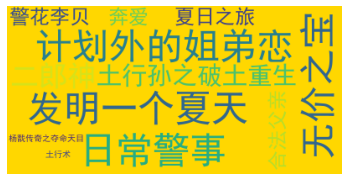

<Figure size 432x288 with 0 Axes>

In [ ]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/feel-free-3566550_1280.png"
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'
ls = df_focus_narrowed['片名'].to_list() + ls_ptitles 
# highlights
print(ls)

#mask = np.array(Image.open(path_image)) # 定义词频背景
wc = WordCloud(
    font_path=path_font,
#    mask=mask, # set back ground mask image
    max_words=50,
    max_font_size=44,
    background_color='gold'
)
wc.generate(','.join(ls))

#image_colors = wordcloud.ImageColorGenerator(mask)
#wc.recolor(color_func=image_colors)
plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show()

plt.savefig(path_img + '/img_title_' + issue_name + '.png', format="png")

## 2.5 生成摘要
2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。

## 2.6 指向电影剧官网


In [ ]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['备案单位'].str.extract('('+ pat_public + ")")
df_f = df_focus_narrowed.groupby('单位简称')['片名'].apply(
    lambda x: '、'.join('《' + x + '》')).rename('关注影片').reset_index()
#####
S0 = '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
S0 +=  '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  S0 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
S0 += '的电影备案公示发布，其中'
S0 += '最遥远的是{}的《{}》，'.format(df_curr_sorted.loc[0, '备案立项号'], df_curr_sorted.loc[0, '片名'])
S0 += '最近期的是{}的《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, 
                                                 '备案立项号'], df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
S0 += '慷田AI聚焦、重点关注的项目有'
for i, row in df_f.iterrows():
  if i == df_f.shape[0]-1:
    S0 = S0.rstrip('、')
    S0 += '以及{co}的{film}'.format(co=row['单位简称'], film=row['关注影片'])
  else:
    S0 += '{co}的{film}、'.format(co=row['单位简称'], film=row['关注影片'])
S0 += '。'
print(S0)

2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。


#[3] Output Word Document

## 3.1 Install and Load Libraries

In [ ]:
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

## 3.2 Output Docx


In [158]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'China Movie Registration Overview ' + issue_name

doc.add_heading(T0, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T1)
doc.add_picture('/content/drive/MyDrive/Github/Content/tools/articles/img/img_title_202103.png')
doc.add_paragraph(T2)


table = doc.add_table(rows=1, cols=1, style='Light List Accent 1')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

table.columns[0].width=Inches(0.5)
doc.add_paragraph(T3)



doc.save(path_doc + '/overview_' + issue_name + '.docx' )


In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'China Movie Registration Overview ' + issue_name

doc.add_heading(T0, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T1)
doc.add_picture(path_img + '/img_title_' + issue_name + '.png')
doc.add_paragraph(T2)


table = doc.add_table(rows=1, cols=1, style='Light List Accent 1')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

table.columns[0].width=Inches(0.5)
doc.add_paragraph(T3)



doc.save(path_doc + '/overview_' + issue_name + '.docx' )


In [ ]:
p = document.add_paragraph('A plain paragraph having some ')

p.add_run('bold').bold = True
p.add_run(' and some ')
p.add_run('italic.').italic = True

document.add_heading('Heading, level 1', level=1)
document.add_paragraph('Intense quote', style='Intense Quote')

document.add_paragraph(
    'first item in unordered list', style='List Bullet'
)
document.add_paragraph(
    'first item in ordered list', style='List Number'
)

document.add_picture('monty-truth.png', width=Inches(1.25))

records = (
    (3, '101', 'Spam'),
    (7, '422', 'Eggs'),
    (4, '631', 'Spam, spam, eggs, and spam')
)

table = document.add_table(rows=1, cols=3)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Qty'
hdr_cells[1].text = 'Id'
hdr_cells[2].text = 'Desc'
for qty, id, desc in records:
    row_cells = table.add_row().cells
    row_cells[0].text = str(qty)
    row_cells[1].text = id
    row_cells[2].text = desc

document.add_page_break()

document.save('demo.docx')